In [128]:
import meep as mp
import math
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [129]:
resolution = 25        # pixels/μm

dpml = 1.0             # PML thickness
dsub = 3.0             # substrate thickness
dpad = 3.0             # padding between grating and PML
gp = 2.4              # grating period
gh = 0.5               # grating height
gdc = 0.5              # grating duty cycle

nperiods = 20          # number of unit cells in finite periodic grating

ff_distance = 1e8      # far-field distance from near-field monitor
ff_angle = 70          # far-field cone angle
ff_npts = 500          # number of far-field points

ff_length = ff_distance*math.tan(math.radians(ff_angle))
ff_res = ff_npts/ff_length

sx = dpml+dsub+gh+dpad+dpml
cell_size = mp.Vector3(sx)

In [130]:
pml_layers = [mp.PML(thickness=dpml,direction=mp.X)]

symmetries = [mp.Mirror(mp.Y)]

wvl_min = 0.4           # min wavelength
wvl_max = 0.6           # max wavelength
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width

src_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub)
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Ez, center=src_pt)]

k_point = mp.Vector3()

glass = mp.Medium(index=1.5)

In [131]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=k_point,
                    default_material=glass,
                    sources=sources)

nfreq = 21
n2f_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad)
n2f_obj = sim.add_near2far(fcen, df, nfreq, mp.Near2FarRegion(center=n2f_pt))

In [132]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, n2f_pt, 1e-9))

ff_source = sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(ff_distance,0.5*ff_length), size=mp.Vector3(y=ff_length))

sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 4.88758e-05 s
Working in 2D dimensions.
Computational cell is 8.52 x 0.04 x 0 with resolution 25
time for set_epsilon = 0.000525951 s
-----------
field decay(t = 50.02): 0.10083813086471573 / 0.10083813086471573 = 1.0
field decay(t = 100.04): 3.880701364536054e-16 / 0.10083813086471573 = 3.848446347882426e-15
run 0 finished at t = 100.04 (5002 timesteps)


     block, center = (0,0,0)
          size (0.5,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)


<AxesSubplot:xlabel='X', ylabel='Y'>

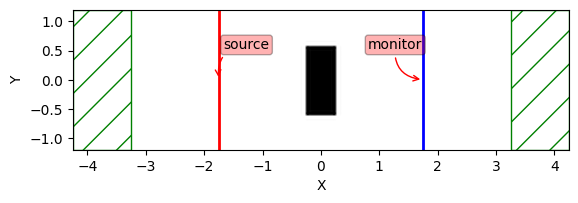

In [133]:
sy = gp
cell_size = mp.Vector3(sx,sy)

sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df), 
                    component=mp.Ez,
                    center=src_pt,
                    size=mp.Vector3(y=sy),
                    )]

geometry = [
    # mp.Block(material=glass, size=mp.Vector3(dpml+dsub,mp.inf,mp.inf), center=mp.Vector3(-0.5*sx+0.5*(dpml+dsub))),
    mp.Block(material=glass, size=mp.Vector3(gh,gdc*gp,mp.inf), center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh))
]

sim = mp.Simulation(resolution=resolution,
                    split_chunks_evenly=True,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    k_point=k_point,
                    sources=sources,
                    symmetries=symmetries)

n2f_obj = sim.add_near2far(fcen, df, nfreq, mp.Near2FarRegion(center=n2f_pt, size=mp.Vector3(y=sy)), nperiods=nperiods)

sim.plot2D(output_plane=mp.Volume(center=mp.Vector3(), size=mp.Vector3(sx,gp)), labels=True)



In [134]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, n2f_pt, 1e-9))

ff_unitcell = sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(ff_distance,0.5*ff_length), size=mp.Vector3(y=ff_length))

-----------
Initializing structure...
Halving computational cell along direction y
time for choose_chunkdivision = 0.000355959 s
Working in 2D dimensions.
Computational cell is 8.52 x 2.4 x 0 with resolution 25
     block, center = (0,0,0)
          size (0.5,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.0100598 s
-----------
field decay(t = 50.02): 0.48295278981899215 / 0.48295278981899215 = 1.0
field decay(t = 100.04): 1.6104651045845192e-05 / 0.48295278981899215 = 3.334622220917519e-05
field decay(t = 150.06): 1.4463825089462096e-06 / 0.48295278981899215 = 2.99487349371831e-06
field decay(t = 200.08): 1.332112551155028e-06 / 0.48295278981899215 = 2.758266603355363e-06
field decay(t = 250.1): 5.023685048856786e-07 / 0.48295278981899215 = 1.0402020973395004e-06
field decay(t = 300.12): 7.005702658863243e-07 / 0.48295278981899215 = 1.45059782375187e-06
field decay(t = 350.14): 7.02079124813

     block, center = (0,0,0)
          size (0.5,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)


<AxesSubplot:xlabel='X', ylabel='Y'>

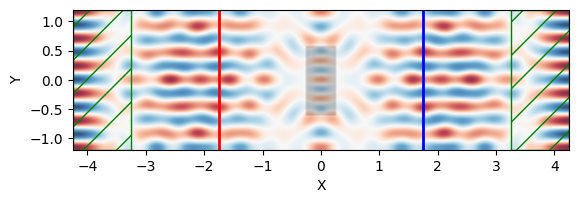

In [135]:
sim.plot2D(fields=mp.Ez)

TypeError: Dimensions of C (498, 20) are incompatible with X (21) and/or Y (500); see help(pcolormesh)

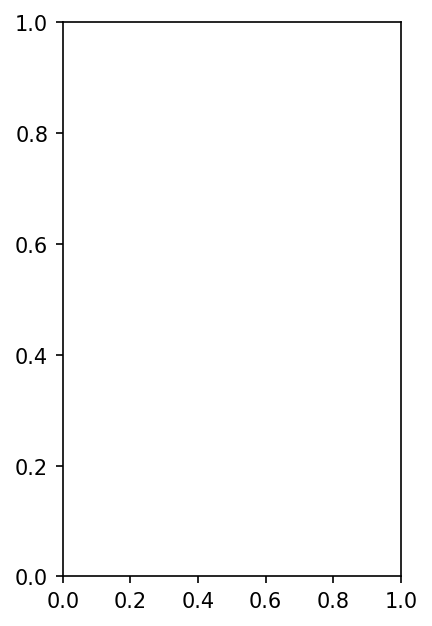

In [136]:
sim.reset_meep()

freqs = mp.get_near2far_freqs(n2f_obj)
wvl = np.divide(1,freqs)
ff_lengths = np.linspace(0,ff_length,ff_npts)
angles = [math.degrees(math.atan(f)) for f in ff_lengths/ff_distance]

wvl_slice = 0.5
idx_slice = np.where(np.asarray(freqs) == 1/wvl_slice)[0][0]

rel_enh = np.absolute(ff_unitcell['Ez'])**2/np.absolute(ff_source['Ez'])**2

plt.figure(dpi=150)

plt.subplot(1,2,1)
plt.pcolormesh(wvl,angles,np.transpose(np.transpose(rel_enh[:-1])[:-1]),cmap='Blues',shading='flat')
plt.axis([wvl_min,wvl_max,0,ff_angle])
plt.xlabel("wavelength (μm)")
plt.ylabel("angle (degrees)")
plt.grid(linewidth=0.5,linestyle='--')
plt.xticks([t for t in np.arange(wvl_min,wvl_max+0.1,0.1)])
plt.yticks([t for t in range(0,ff_angle+1,10)])
plt.title("far-field spectra")

plt.subplot(1,2,2)
plt.plot(angles,rel_enh[:,idx_slice],'bo-')
plt.xlim(0,ff_angle)
plt.ylim(0)
plt.xticks([t for t in range(0,ff_angle+1,10)])
plt.xlabel("angle (degrees)")
plt.ylabel("relative enhancement")
plt.grid(axis='x',linewidth=0.5,linestyle='--')
plt.title("f.-f. spectra @  λ = {:.1} μm".format(wvl_slice))

plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
I = np.array([a[0] for a in np.absolute(ff_unitcell['Ez'])**2])
angles = np.array(angles)

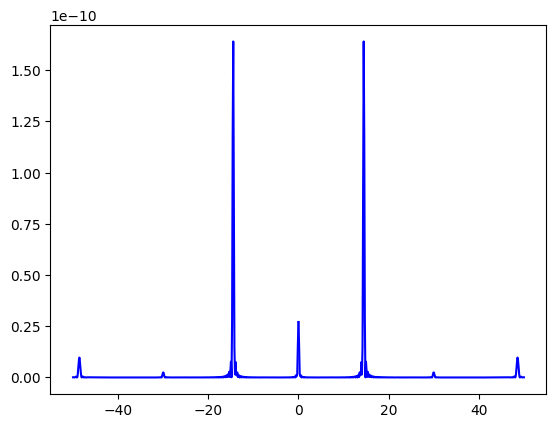

In [ ]:
plt.plot(angles, I, 'b')
plt.plot(-angles, I, 'b')